# Create model arquitecture

In [95]:
from tensorflow.keras import layers
from tensorflow import keras, dtypes
from tensorflow.data import Dataset
from tensorflow import feature_column
import tensorflow as tf

from preprocess_tf import preprocessing_fn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target_name, shuffle=True, batch_size=100):
    dataframe = dataframe.copy()
    targets = dataframe.pop(target_name)
    ds = Dataset.from_tensor_slices((dict(dataframe), targets))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [3]:
def set_numerical_feature(name):
    
    numerical_feature = feature_column.numeric_column(name, dtype=dtypes.float64)
    
    return numerical_feature
    
def set_one_hot_feature(name, data):
    one_hot_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    one_hot_feature = feature_column.indicator_column(one_hot_feature)
    
    return one_hot_feature

def set_embedding_feature(name, data, dims):
    embedding_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    embedding_feature = feature_column.embedding_column(embedding_feature, dimension=dims)
    
    return embedding_feature

In [4]:
def feature_columns(data, dataset):
    
    feature_columns = []

    # numeric cols
    for header in ['yearOfRegistration', 'powerPS', 'kilometer']:
        feature_columns.append(set_numerical_feature(header))

    feature_columns.append(set_one_hot_feature('abtest', data))
    
    feature_columns.append(set_embedding_feature('vehicleType', data, 5))
    
    feature_columns.append(set_one_hot_feature('gearbox', data))
    
    #feature_columns.append(set_embedding_feature('model', data, 15))
    #feature_columns.append(set_one_hot_feature('model', data))
    
    feature_columns.append(set_one_hot_feature('fuelType', data))
    
    #feature_columns.append(set_embedding_feature('brand', data, 10))
    #feature_columns.append(set_one_hot_feature('brand', data))
    
    feature_columns.append(set_one_hot_feature('notRepairedDamage', data))
    
    #feature_columns.append(set_embedding_feature('postalCode', data, 10))
    feature_columns.append(set_one_hot_feature('cluster_pcode', data))
    
    feature_columns.append(set_one_hot_feature('cluster_model', data))
    
    feature_columns.append(set_one_hot_feature('cluster_brand', data))
    

    feature_layer = layers.DenseFeatures(feature_columns)
    
    return(feature_layer)

In [9]:
train = preprocessing_fn(path='data/train.csv', na_encoding='data/gearbox_powerps_na.csv', norm_params='data/numerical_features_normalization.csv', brand_clusters='data/brand_clusters.csv', model_clusters='data/model_clusters.csv', postalcode_clusters='data/postalcode_clusters.csv')
val = preprocessing_fn(path='data/val.csv', na_encoding='data/gearbox_powerps_na.csv', norm_params='data/numerical_features_normalization.csv', brand_clusters='data/brand_clusters.csv', model_clusters='data/model_clusters.csv', postalcode_clusters='data/postalcode_clusters.csv')

print(train.shape)
print(val.shape)

(165947, 12)
(41246, 12)


In [10]:
train.dtypes

price                   int64
abtest                 object
vehicleType            object
yearOfRegistration    float32
gearbox                object
powerPS               float32
kilometer             float32
fuelType               object
notRepairedDamage      object
cluster_brand           int32
cluster_model           int32
cluster_pcode           int32
dtype: object

In [11]:
train_ds = df_to_dataset(dataframe=train, target_name='price', shuffle=True, batch_size=512)
val_ds = df_to_dataset(dataframe=val, target_name='price', shuffle=True, batch_size=512)

In [12]:
feature_layer = feature_columns(train, train_ds)

In [106]:
dp_rate = 0.1
lr = 0.001
beta_1 = 0.9
hu = 150

model = keras.Sequential([
    feature_layer,
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(1, activation='relu')
])

# Compile Keras model
model.compile(
    loss='mean_absolute_error',
    metrics=['mean_absolute_error','mean_squared_error'],
    optimizer=keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1))

# fit model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

# get results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(hist.epoch, hist.mean_absolute_error)
plt.plot(hist.epoch, hist.val_mean_absolute_error)

Epoch 1/30
325/325 [==============================] - 7s 23ms/step - loss: -1.4717 - mean_absolute_error: 3140.2705 - mean_squared_error: 16588246.0000 - val_loss: -1.4709 - val_mean_absolute_error: 3134.3816 - val_mean_squared_error: 16526987.0000
Epoch 2/30
325/325 [==============================] - 7s 21ms/step - loss: -1.4717 - mean_absolute_error: 3140.2700 - mean_squared_error: 16588243.0000 - val_loss: -1.4719 - val_mean_absolute_error: 3134.3818 - val_mean_squared_error: 16526987.0000
Epoch 3/30
325/325 [==============================] - 7s 21ms/step - loss: -1.4715 - mean_absolute_error: 3140.2698 - mean_squared_error: 16588248.0000 - val_loss: -1.4723 - val_mean_absolute_error: 3134.3811 - val_mean_squared_error: 16526987.0000
Epoch 4/30
 97/325 [=======>......................] - ETA: 4s - loss: -1.4792 - mean_absolute_error: 3141.0022 - mean_squared_error: 16566081.0000

KeyboardInterrupt: 

In [62]:
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,1067.398682,1067.398682,2991982.750,926.244751,926.244751,1947421.500,0
1,871.227478,871.227478,1739894.625,845.243835,845.243835,1633754.375,1
2,849.495605,849.495605,1640014.500,859.100586,859.100586,1640125.000,2
3,827.022400,827.022400,1551690.000,837.264587,837.264587,1552989.625,3
4,816.540527,816.540527,1501558.875,811.320007,811.320007,1467183.375,4
5,809.363831,809.363831,1474239.875,883.349365,883.349365,1721600.250,5
6,806.873352,806.873352,1461948.000,996.305115,996.305115,2077289.625,6
7,801.009216,801.009216,1439583.125,827.972656,827.972656,1470910.625,7
8,792.898621,792.898621,1414805.500,812.021606,812.021606,1470331.375,8
9,785.930420,785.930420,1392498.375,866.145386,866.145386,1611054.375,9


In [63]:
train_pred = model.predict(df_to_dataset(dataframe=train, target_name='price', shuffle=False, batch_size=1000)).flatten() 

In [64]:
# super baseline model
np.mean(np.abs(train.price - train.price.mean()))

2138.1648503177207

In [65]:
# my model
np.mean(np.abs(train.price - train_pred))

696.2865528339162

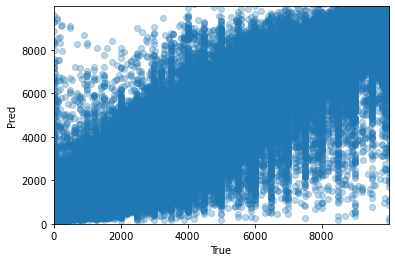

In [68]:
plt.scatter(train.price, train_pred, alpha=0.3)
plt.xlim([0, train.price.max()])
plt.ylim([0, train.price.max()])
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

In [69]:
train['price_pred'] = train_pred
train['abs_error'] = abs(train.price_pred - train.price)
train['error'] = train.price_pred - train.price

worst_predictions = train.copy().loc[train.abs_error >= train.abs_error.quantile(0.9)]

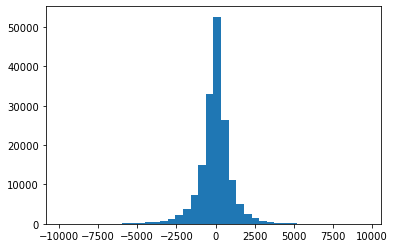

In [70]:
plt.hist(train.error, bins=40)
plt.show()

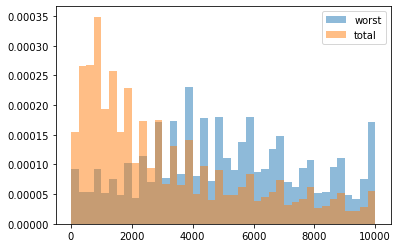

In [71]:
plt.hist(worst_predictions.price, bins=40, alpha=0.5, density=True, label='worst')
plt.hist(train.price, bins=40, alpha=0.5, density=True, label='total')
plt.legend()
plt.show()

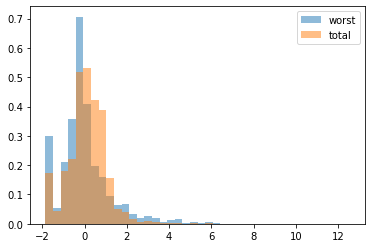

In [72]:
plt.hist(worst_predictions.yearOfRegistration, bins=40, alpha=0.5, density=True, label='worst')
plt.hist(train.yearOfRegistration, bins=40, alpha=0.5, density=True, label='total')
plt.legend()
plt.show()

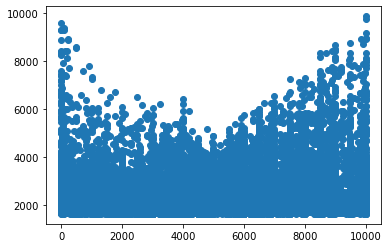

In [73]:
plt.scatter(worst_predictions.price, worst_predictions.abs_error)
plt.show()

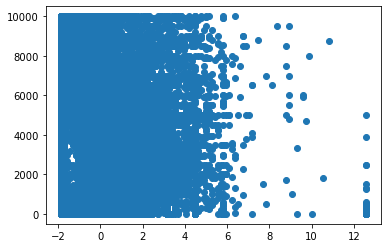

In [74]:
plt.scatter(train.yearOfRegistration, train.price)

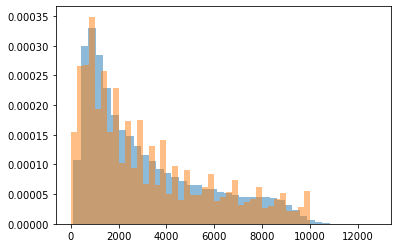

In [75]:
plt.hist(train.price_pred, bins=40, alpha=0.5, density=True)
plt.hist(train.price, bins=40, alpha=0.5, density=True)
plt.show()

In [83]:
i = 9000
print(train.price[i])
print(train.price_pred[i])

2100
1161.5856


In [84]:
train.price.mean()

3140.270146492555